## Disclaimer:

### O notebook em questão possui como objetivo a vizualisação e exploração de dados dos estudantes da Universidade Federal de Lavras (UFLA). Os dados em questão estão disponíveis para consulta pública [aqui](https://dados.gov.br/dados/conjuntos-dados/estudantes-da-graduacao). A ferramenta utilizada para manipulação dos dados foi o `PySpark`.

In [30]:
# Criação da sessão Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("data_exploration").getOrCreate()
import warnings
warnings.filterwarnings('ignore')

### SETUP

In [74]:
# IMPORTS
import random
import pyspark.pandas as ps
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, split
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import rand, when

### DATA VIEW

In [32]:
# Carregando os dados como um objeto PySpark
data = spark.read.csv('dados_abertos___estudantes_da_graduacao_2024-02-22T12_08_52.899842-03_00.csv', header=True, inferSchema=True)
type(data)

pyspark.sql.dataframe.DataFrame

In [33]:
# Tabela com os dados
data.show()

+------------------+--------------------+--------------------------+---------------------+------------------+------------------------+--------------+-------------------+-------------------+-----------+-----------+----------------------+------------------+----------------+-----------------+--------------------+--------------+--------------+--------------+--------------------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|situacao_estudante|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|codigo_oferta_curso|codigo_inep|curso_turno|nome_matriz_curricular|  titulo_academico|curso_modalidade|    situacao_nome|  situacao_descricao|situacao_censo|        campus|sistema_origem| data_atualizacao_dw|
+------------------+--------------------+--------------------------+---------------------+------------------+------------------------+--------------+-------------------+-------------------+-----------+-----------+----------------------+--------

In [34]:
# Para plotar os gráficos no notebook
%matplotlib inline

In [35]:
# Para melhor manipulação trasnforma o objeto em SparkPandas
view_1 = ps.DataFrame(data.groupBy('semestre_letivo_referencia', 'situacao_descricao')
                      .count()
                      .orderBy('semestre_letivo_referencia'))

view_1_pivot = view_1.pivot(index='semestre_letivo_referencia', 
                            columns='situacao_descricao', 
                            values='count')
view_1_pivot.plot(kind='bar')

In [36]:
# Para melhor manipulação trasnforma o objeto em SparkPandas
view_2 = ps.DataFrame(data.groupBy('semestre_letivo_referencia', 'situacao_estudante')
                      .count()
                      .orderBy('semestre_letivo_referencia'))

view_2_pivot = view_2.pivot(index='semestre_letivo_referencia', 
                            columns='situacao_estudante', 
                            values='count')
view_2_pivot.plot(kind='bar')

In [37]:
view_2 = data.groupBy('situacao_estudante').count()
total = view_2.groupBy().agg(F.sum('count').alias('total')).collect()[0]['total']
view_2 = view_2.withColumn('percent', (F.col('count') / total) * 100)

view_2 = ps.DataFrame(view_2)
view_2 = view_2.set_index('situacao_estudante')
view_2.plot(kind='pie',y='percent')

In [38]:
# Para melhor manipulação trasnforma o objeto em SparkPandas
view_3 = ps.DataFrame(data.groupBy('semestre_letivo_referencia', 'curso')
                      .count()
                      .orderBy('semestre_letivo_referencia'))

view_3_pivot = view_3.pivot(index='semestre_letivo_referencia', 
                            columns='curso', 
                            values='count')
view_3_pivot.plot(kind='bar')

In [39]:
# Para melhor manipulação trasnforma o objeto em SparkPandas
view_4 = ps.DataFrame(data.groupBy('curso', 'curso_turno')
                      .count()
                      .orderBy('curso'))

view_4_pivot = view_4.pivot(index='curso', 
                            columns='curso_turno', 
                            values='count')
view_4_pivot.plot(kind='barh')

In [40]:
# Para melhor manipulação trasnforma o objeto em SparkPandas
view_5 = ps.DataFrame(data.groupBy('semestre_letivo_referencia', 'curso_turno')
                      .count()
                      .orderBy('semestre_letivo_referencia'))

view_5_pivot = view_5.pivot(index='semestre_letivo_referencia', 
                            columns='curso_turno', 
                            values='count')
view_5_pivot.plot(kind='bar')

### Tratamento dos dados:

In [41]:
valores_unicos_lista = data.select("situacao_descricao").distinct().collect()
valores_unicos_lista = [row["situacao_descricao"] for row in valores_unicos_lista]

In [42]:
situacao_descricao_to_pop = ['Discente trancou o curso por um período',
                            'Conclusão dos requisitos acadêmicos ou titulação',
                            'Aluno vinculado a UFLA, sem cursar disciplinas.',
                            'Discente transferido para outra instituição',
                            'Saiu do curso em função de desligamento por insuficiência ou outros',
                            'Discente solicitou explicitamente a saída do curso',
                            'Discente não compareceu ao curso por um período e, com isso, perdeu a vaga',
                            'Discente realizando Atividade Acadêmica Internacional, regulamentada pela Resolução CEPE 121/2014',
                            'Falecimento do discente',
                            'Programa de Mobilidade Estudantil',
                            'Discente desligado por não renovação de matrícula',
                            'Saiu do curso em função de desligamento por tempo (não concluiu o curso no tempo previsto)',
                            'Encerrou o período de trancamento geral no curso',
                            'Mudança do discente de um curso para uma habilitação ou de uma área básica para um curso/habilitação relacionados',
                            'Conclusão dos requisitos acadêmicos ou titulação com apostilamento',
                            ]

In [43]:
#Tratamento #1: Remoção de alunos com perfil inadequado
data = data.filter(~data["situacao_descricao"].isin(situacao_descricao_to_pop))

In [44]:
data.show()

+------------------+--------------------+--------------------------+---------------------+------------------+------------------------+--------------+-------------------+-------------------+-----------+-----------+----------------------+--------------------+----------------+-------------+--------------------+--------------+--------------+--------------+--------------------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|situacao_estudante|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|codigo_oferta_curso|codigo_inep|curso_turno|nome_matriz_curricular|    titulo_academico|curso_modalidade|situacao_nome|  situacao_descricao|situacao_censo|        campus|sistema_origem| data_atualizacao_dw|
+------------------+--------------------+--------------------------+---------------------+------------------+------------------------+--------------+-------------------+-------------------+-----------+-----------+----------------------+------------

In [45]:
situacao_estudante_to_pop = ['Inativo']
data = data.filter(~data["situacao_estudante"].isin(situacao_estudante_to_pop))
data.show()

+------------------+--------------------+--------------------------+---------------------+------------------+------------------------+--------------+-------------------+-------------------+-----------+-----------+----------------------+--------------------+----------------+-------------+--------------------+--------------+--------------+--------------+--------------------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|situacao_estudante|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|codigo_oferta_curso|codigo_inep|curso_turno|nome_matriz_curricular|    titulo_academico|curso_modalidade|situacao_nome|  situacao_descricao|situacao_censo|        campus|sistema_origem| data_atualizacao_dw|
+------------------+--------------------+--------------------------+---------------------+------------------+------------------------+--------------+-------------------+-------------------+-----------+-----------+----------------------+------------

In [46]:
# Schema dos dados
data.printSchema()

root
 |-- registro_academico: integer (nullable = true)
 |-- curso: string (nullable = true)
 |-- semestre_letivo_referencia: string (nullable = true)
 |-- ano_letivo_referencia: date (nullable = true)
 |-- situacao_estudante: string (nullable = true)
 |-- semestre_letivo_ingresso: string (nullable = true)
 |-- forma_ingresso: string (nullable = true)
 |-- forma_ingresso_tipo: string (nullable = true)
 |-- codigo_oferta_curso: string (nullable = true)
 |-- codigo_inep: integer (nullable = true)
 |-- curso_turno: string (nullable = true)
 |-- nome_matriz_curricular: integer (nullable = true)
 |-- titulo_academico: string (nullable = true)
 |-- curso_modalidade: string (nullable = true)
 |-- situacao_nome: string (nullable = true)
 |-- situacao_descricao: string (nullable = true)
 |-- situacao_censo: string (nullable = true)
 |-- campus: string (nullable = true)
 |-- sistema_origem: string (nullable = true)
 |-- data_atualizacao_dw: timestamp (nullable = true)



In [47]:
#Remoção de variáveis fora do contexto
columns_to_drop = ['situacao_estudante', 
                   'codigo_oferta_curso', 
                   'codigo_inep',
                   'nome_matriz_curricular', 
                   'titulo_academico', 
                   'situacao_nome', 
                   'situacao_descricao', 
                   'data_atualizacao_dw',
                   'sistema_origem']

data_cleaned = data.drop(*columns_to_drop)
data_cleaned.show()

+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|curso_turno|curso_modalidade|situacao_censo|        campus|
+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+
|         202325010|Bacharelado Inter...|                    2023/2|           2023-01-01|                  2023/2|   SiSU (Enem)|            Regular|   Integral|      Presencial|      Cursando|Campus Paraíso|
|         202325009|Bacharelado Inter...|                    2023/2|           2023-01-01|                  2023/2|   SiSU (Enem)|            Regular|   Integra

### ADIÇÃO DE DADOS SINTÉTICOS:

In [48]:
random.seed(0)

In [49]:
# Carregando os valores sintéticos
from course_mappings import course_skills, course_interests

In [50]:
def get_random_skills(course):
    skills = course_skills.get(course, [])
    return random.sample(skills, min(len(skills), 3))

def get_random_interests(course):
    interests = course_interests.get(course, [])
    return random.sample(interests, min(len(interests), 3))

get_random_skills_udf = udf(get_random_skills, ArrayType(StringType()))
get_random_interests_udf = udf(get_random_interests, ArrayType(StringType()))

In [51]:
# Aplicar as UDFs para adicionar os campos 'habilidades' e 'interesse'
data_cleaned = data_cleaned.withColumn('habilidades', get_random_skills_udf(data_cleaned['curso']))
data_cleaned = data_cleaned.withColumn('interesses', get_random_interests_udf(data_cleaned['curso']))

# Adição da flag de de estágio com 1 ou 0
data_cleaned = data_cleaned.withColumn('estagiando', when(rand() < 0.3, 1).otherwise(0))

In [52]:
data_cleaned.show()

+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------+--------------------+----------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|curso_turno|curso_modalidade|situacao_censo|        campus|         habilidades|          interesses|estagiando|
+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------+--------------------+----------+
|         202325010|Bacharelado Inter...|                    2023/2|           2023-01-01|                  2023/2|   SiSU (Enem)|            Regular|   Integral|      Presencial|      Cursando|Campus Paraíso|[P

In [53]:
data_cleaned.show(truncate=38)

+------------------+--------------------------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------------------------+--------------------------------------+----------+
|registro_academico|                                 curso|semestre_letivo_referencia|ano_letivo_referencia|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|curso_turno|curso_modalidade|situacao_censo|        campus|                           habilidades|                            interesses|estagiando|
+------------------+--------------------------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------------------------+--------------------------------------+----------+
|         202325010|Bacharelado Interdisciplinar 

NameError: name 'split' is not defined

In [ ]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, split


# Inicialize o Word2Vec
word2Vec_habilidades = Word2Vec(vectorSize=3, minCount=0, inputCol="habilidades", outputCol="habilidades_vec")
word2Vec_interesses = Word2Vec(vectorSize=3, minCount=0, inputCol="interesses", outputCol="interesses_vec")

# Construa o pipeline
pipeline = Pipeline(stages=[word2Vec_habilidades, word2Vec_interesses])

# Treine o modelo
model = pipeline.fit(data_cleaned)

# Transforme os dados
data_transformed = model.transform(data_cleaned)

# Mostrar os resultados
data_transformed.select("habilidades_vec", "interesses_vec").show()


### CLUSTERIZAÇÃO DOS DADOS:

In [81]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, split

# Inicialize o Word2Vec
word2Vec_habilidades = Word2Vec(vectorSize=3, minCount=0, inputCol="habilidades", outputCol="habilidades_vec")
word2Vec_interesses = Word2Vec(vectorSize=3, minCount=0, inputCol="interesses", outputCol="interesses_vec")

# Construa o pipeline
pipeline = Pipeline(stages=[word2Vec_habilidades, word2Vec_interesses])

# Treine o modelo
model = pipeline.fit(data_cleaned)

# Transforme os dados
data_transformed = model.transform(data_cleaned)

# Mostrar os resultados
data_transformed.show()

+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------+--------------------+----------+--------------------+--------------------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|curso_turno|curso_modalidade|situacao_censo|        campus|         habilidades|          interesses|estagiando|     habilidades_vec|      interesses_vec|
+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------+--------------------+----------+--------------------+--------------------+
|         202325010|Bacharelado Inter...|                    2023/2|           2023-0

In [82]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

In [83]:
# Inicialize os encoders para as variáveis categóricas
categorical_columns = ['curso', 'forma_ingresso', 'curso_turno', 'curso_modalidade', 'campus']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").setHandleInvalid("keep") for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_ohe") for indexer in indexers]

In [84]:
# Assemble todas as colunas de features em um único vetor
assembler_inputs = [encoder.getOutputCol() for encoder in encoders] + ['habilidades_vec', 'interesses_vec']
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [85]:
# Escalonar as features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [86]:
# Inicializar o KMeans
kmeans = KMeans(featuresCol="scaledFeatures", k=10)

In [87]:
# Construir o pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])

In [89]:
# Treinar o modelo
model = pipeline.fit(data_transformed)

In [90]:
# Fazer previsões
predictions = model.transform(data_transformed)

In [93]:
predictions.show()

+------------------+--------------------+--------------------------+---------------------+------------------------+--------------+-------------------+-----------+----------------+--------------+--------------+--------------------+--------------------+----------+--------------------+--------------------+-----------+--------------------+-----------------+----------------------+------------+---------------+------------------------+---------------------+--------------------------+----------------+--------------------+--------------------+----------+
|registro_academico|               curso|semestre_letivo_referencia|ano_letivo_referencia|semestre_letivo_ingresso|forma_ingresso|forma_ingresso_tipo|curso_turno|curso_modalidade|situacao_censo|        campus|         habilidades|          interesses|estagiando|     habilidades_vec|      interesses_vec|curso_index|forma_ingresso_index|curso_turno_index|curso_modalidade_index|campus_index|curso_index_ohe|forma_ingresso_index_ohe|curso_turno_inde

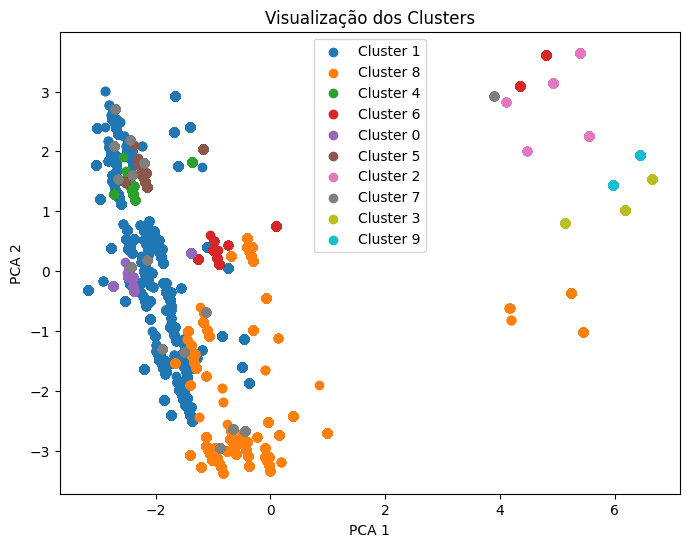

In [97]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt


pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
model_pca = pca.fit(predictions)
result_pca = model_pca.transform(predictions)

result_pca = result_pca.select(col("pcaFeatures"), col("prediction").alias("cluster"))

pandas_df = result_pca.toPandas()

pandas_df['pca_x'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['pca_y'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

plt.figure(figsize=(8, 6))
for cluster in pandas_df['cluster'].unique():
    cluster_df = pandas_df[pandas_df['cluster'] == cluster]
    plt.scatter(cluster_df['pca_x'], cluster_df['pca_y'], label=f'Cluster {cluster}')

plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualização dos Clusters')
plt.show()

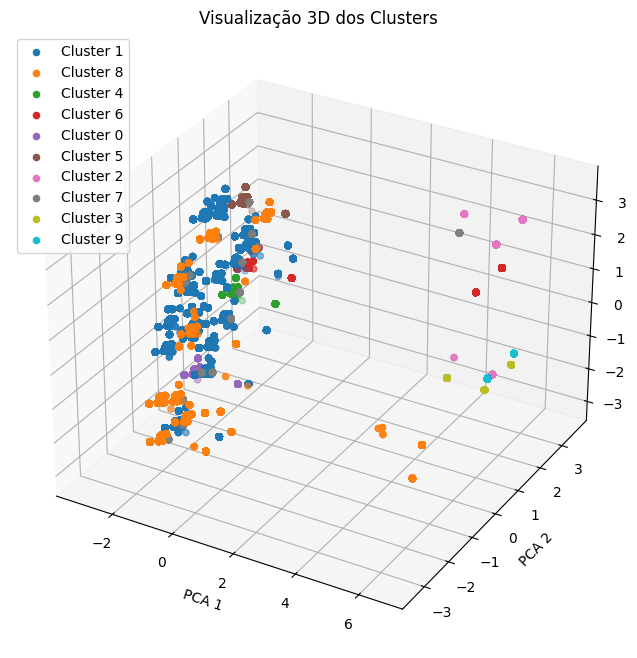

In [99]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assumindo que 'predictions' é o seu DataFrame com as previsões do KMeans

# Reduzir a dimensionalidade para 3D para visualização usando PCA
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pcaFeatures")
model_pca = pca.fit(predictions)
result_pca = model_pca.transform(predictions)

# Selecionar apenas as features reduzidas e a coluna de previsão
result_pca = result_pca.select("pcaFeatures", "prediction")

# Converter para Pandas DataFrame
pandas_df = result_pca.toPandas()

# Extrair as componentes principais
def extract_pca_features_udf(vec, i):
    try:
        return float(vec[i])
    except IndexError:
        return None

extract_pca_features = udf(extract_pca_features_udf, FloatType())

pandas_df['pca_x'] = pandas_df['pcaFeatures'].apply(lambda x: extract_pca_features_udf(x, 0))
pandas_df['pca_y'] = pandas_df['pcaFeatures'].apply(lambda x: extract_pca_features_udf(x, 1))
pandas_df['pca_z'] = pandas_df['pcaFeatures'].apply(lambda x: extract_pca_features_udf(x, 2))

# Plotar o gráfico 3D de dispersão
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in pandas_df['prediction'].unique():
    cluster_df = pandas_df[pandas_df['prediction'] == cluster]
    ax.scatter(cluster_df['pca_x'], cluster_df['pca_y'], cluster_df['pca_z'], label=f'Cluster {cluster}')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()
plt.title('Visualização 3D dos Clusters')
plt.show()

In [ ]:
# Encerra a sessão spark
spark.stop()